In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
import warnings
warnings.filterwarnings("ignore")

# Modeling time series behaviour

## ETS Decomposition
Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [202]:
airline = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


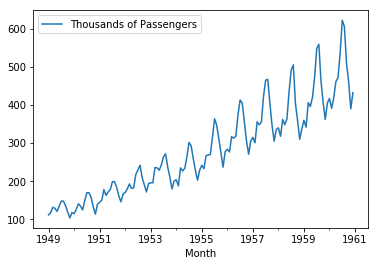

In [203]:
airline.plot();

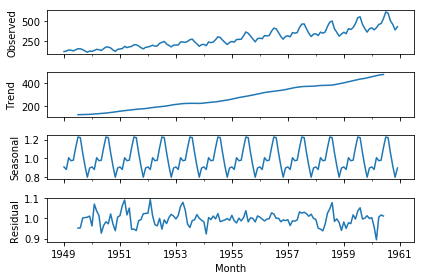

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative')  # model='mul' also works
result.plot();


This is a naive decomposition. More sophisticated methods should be preferred.

The additive model is Y[t] = T[t] + S[t] + e[t]

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

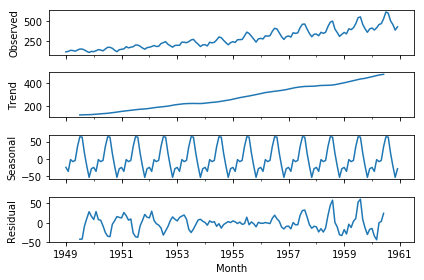

In [205]:
result = seasonal_decompose(airline['Thousands of Passengers'], model='additive')  
result.plot();

In the next section we'll see how to apply exponential smoothing models to each of these contributing factors.


## Simple Moving Average


In [206]:
airline = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)

In [207]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


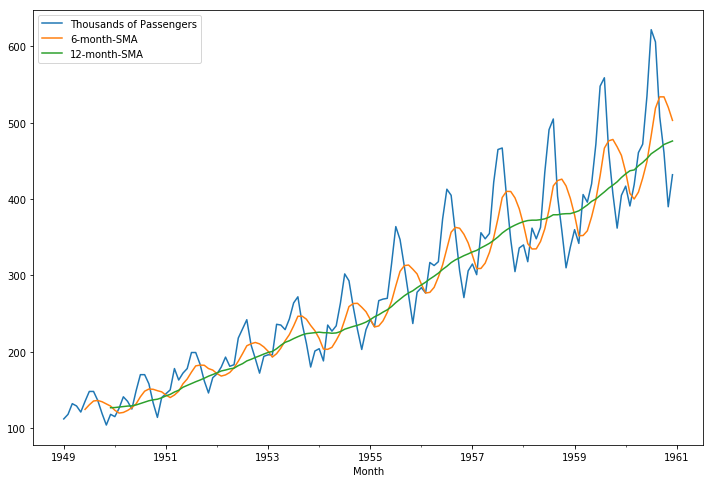

In [208]:
airline.plot(figsize=(12,8));

## EWMA 

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

### Simple Exponential Smoothing with one smoothing factor α

In [209]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

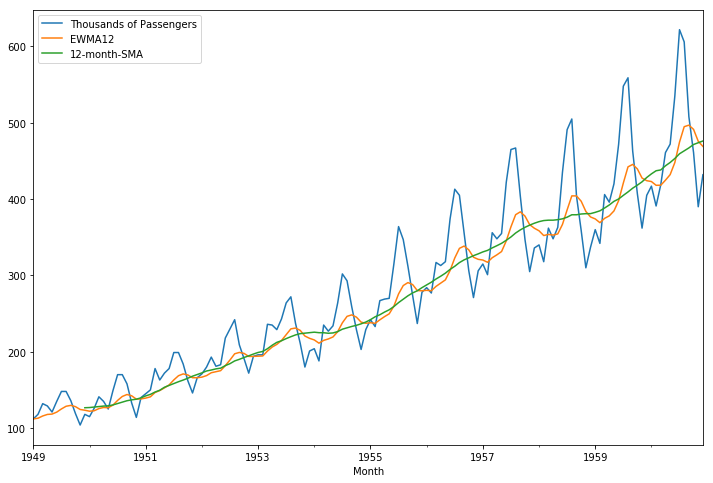

In [210]:
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

The above example employed Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at Double and Triple Exponential Smoothing with the Holt-Winters Methods.

___
## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [211]:
df = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.dropna(inplace=True)
df.index.freq = 'MS'

span = 12
alpha = 2/(span+1)
df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()

In [212]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,DESadd
Month,,,
1949-01-01,112,112.000000,114.336734
1949-02-01,118,112.923077,120.336734
1949-03-01,132,115.857988,134.336734
1949-04-01,129,117.879836,131.336734
1949-05-01,121,118.359861,123.336734


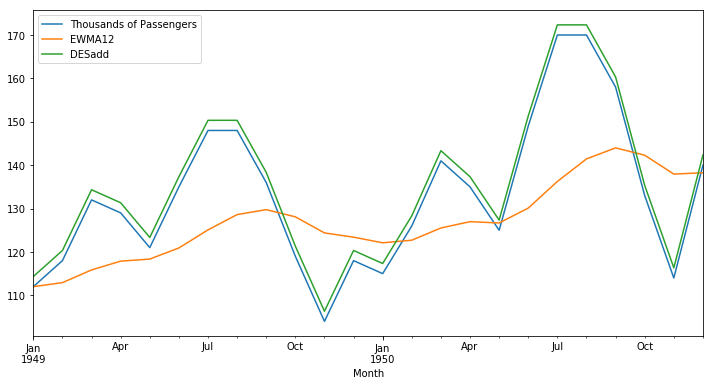

In [213]:
df[['Thousands of Passengers','EWMA12','DESadd']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [214]:
df['DESmul'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,DESadd,DESmul
Month,,,,
1949-01-01,112,112.000000,114.336734,112.049247
1949-02-01,118,112.923077,120.336734,118.051885
1949-03-01,132,115.857988,134.336734,132.058041
1949-04-01,129,117.879836,131.336734,129.056722
1949-05-01,121,118.359861,123.336734,121.053204


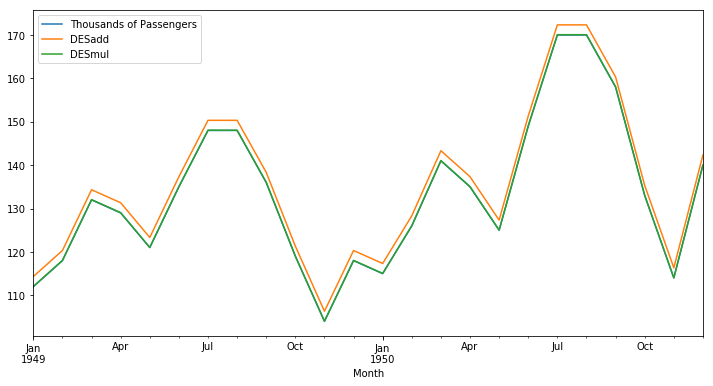

In [215]:
df[['Thousands of Passengers','DESadd','DESmul']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [216]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,DESadd,DESmul,TESadd12
Month,,,,,
1949-01-01,112,112.000000,114.336734,112.049247,113.081280
1949-02-01,118,112.923077,120.336734,118.051885,120.550712
1949-03-01,132,115.857988,134.336734,132.058041,135.527336
1949-04-01,129,117.879836,131.336734,129.056722,133.155093
1949-05-01,121,118.359861,123.336734,121.053204,125.656162


In [217]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,DESadd,DESmul,TESadd12,TESmul12
Month,,,,,,
1949-01-01,112,112.000000,114.336734,112.049247,113.081280,111.603408
1949-02-01,118,112.923077,120.336734,118.051885,120.550712,118.848671
1949-03-01,132,115.857988,134.336734,132.058041,135.527336,133.340887
1949-04-01,129,117.879836,131.336734,129.056722,133.155093,127.904931
1949-05-01,121,118.359861,123.336734,121.053204,125.656162,120.983979


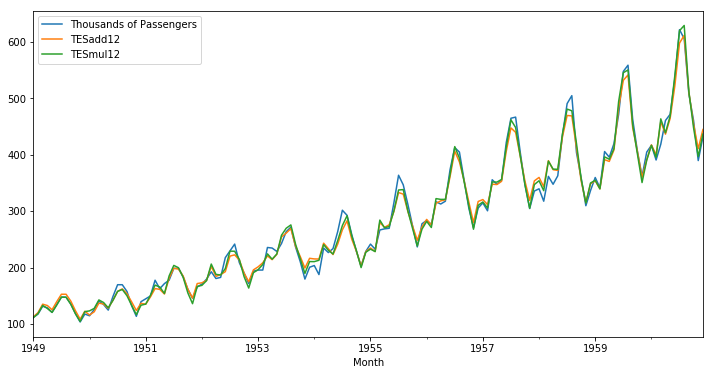

In [218]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

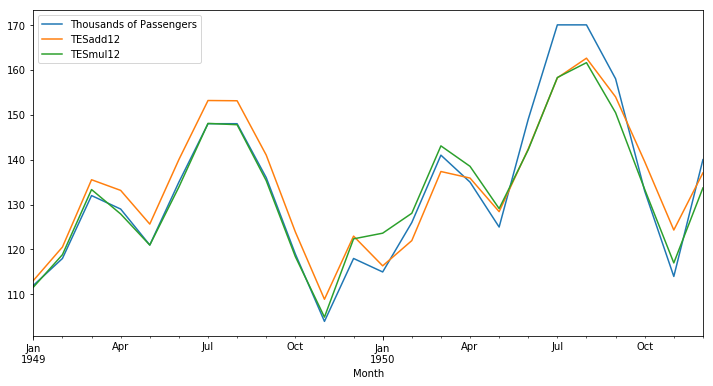

In [219]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - forecasting. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

# Forecasting time series

In [220]:
df = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'

In [221]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


#### Train Test Split

In [222]:
train_data = df.iloc[:108] 
test_data = df.iloc[108:]

#### Fitting the Model

In [223]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()



#### Evaluating Model against Test Set

In [224]:
test_predictions = fitted_model.forecast(36).rename('HW Forecast')


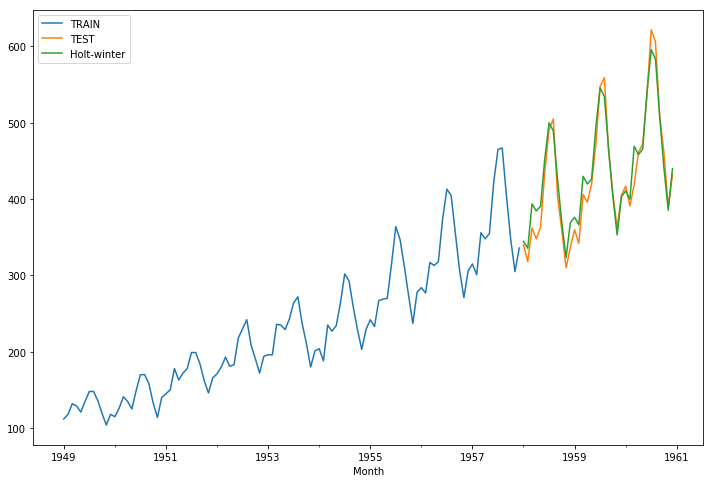

In [225]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8));
test_predictions.plot(legend=True,label='Holt-winter');

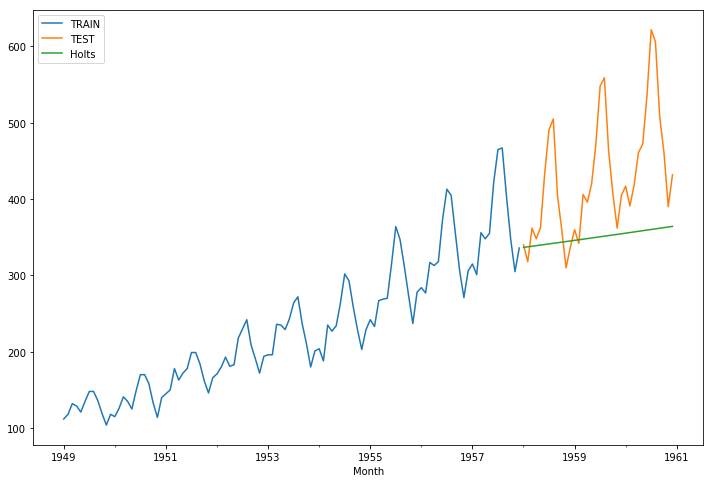

In [226]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(36).rename('Holts')
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8));
test_predictions.plot(legend=True,label='Holts');

#### Evaluation Metrics

In [227]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

print('MAE: ',mean_absolute_error(test_data,test_predictions))
print('MSE: ',mean_squared_error(test_data,test_predictions))
print('RMSE: ',np.sqrt(mean_squared_error(test_data,test_predictions)))

MAE:  81.8651107771408
MSE:  11622.111146913054
RMSE:  107.80589569644627


In [228]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


#### Forecasting into Future

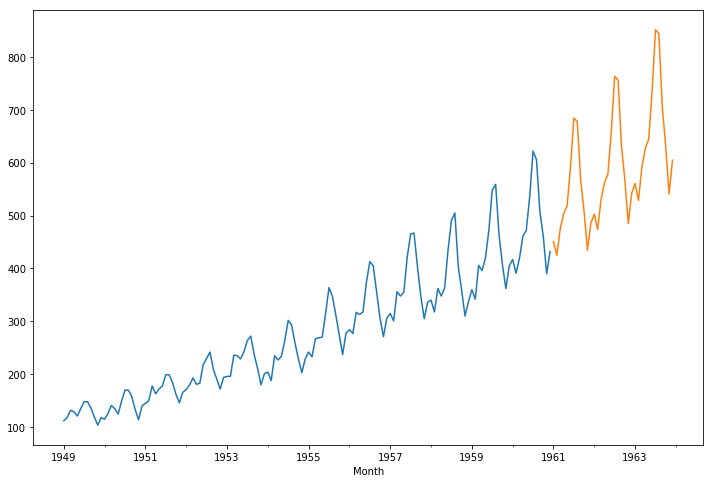

In [229]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

forecast_predictions = final_model.forecast(36)

df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_predictions.plot();

## Stationarity
how to determine if a time series is stationary??

Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

In [230]:
df2 = pd.read_csv('Data/samples.csv',index_col=0,parse_dates=True)
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


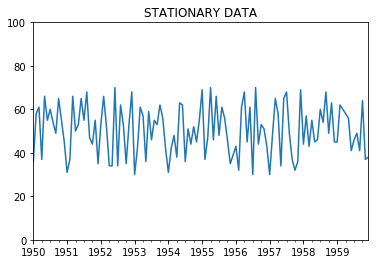

In [231]:
df2['a'].plot(ylim=[0,100],title="STATIONARY DATA").autoscale(axis='x',tight=True);

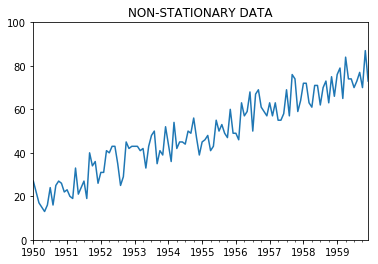

In [232]:
df2['b'].plot(ylim=[0,100],title="NON-STATIONARY DATA").autoscale(axis='x',tight=True);

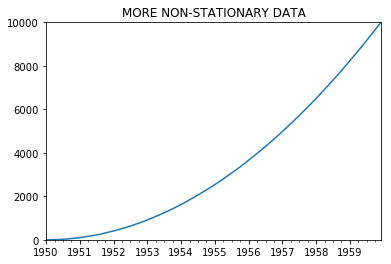

In [233]:
df2['c'].plot(ylim=[0,10000],title="MORE NON-STATIONARY DATA").autoscale(axis='x',tight=True);

### Tests for Stationarity

A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

In [234]:
# Load a seasonal dataset
df1 = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

### Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

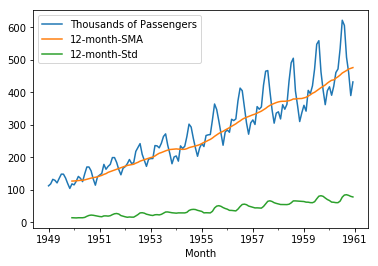

In [235]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

In [236]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [237]:
adf_test(df1['Thousands of Passengers'], 'Thousands of Passengers')


Augmented Dickey-Fuller Test: Thousands of Passengers
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


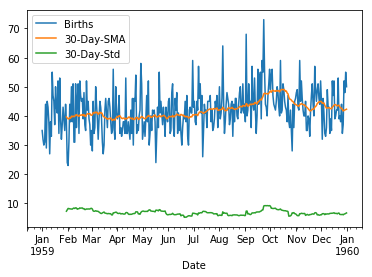

In [238]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [239]:
adf_test(df2['Births'], 'Births')

Augmented Dickey-Fuller Test: Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

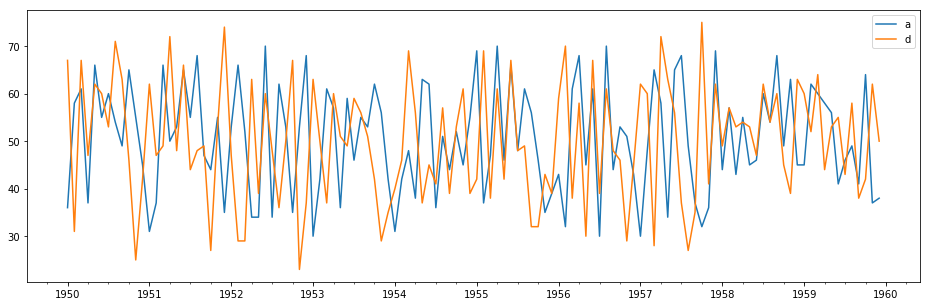

In [240]:
df3 = pd.read_csv('Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));

It's hard to tell from this overlay but df['d'] almost perfectly predicts the behavior of df['a'].
To see this more clearly , we will shift df['d'] two periods forward.

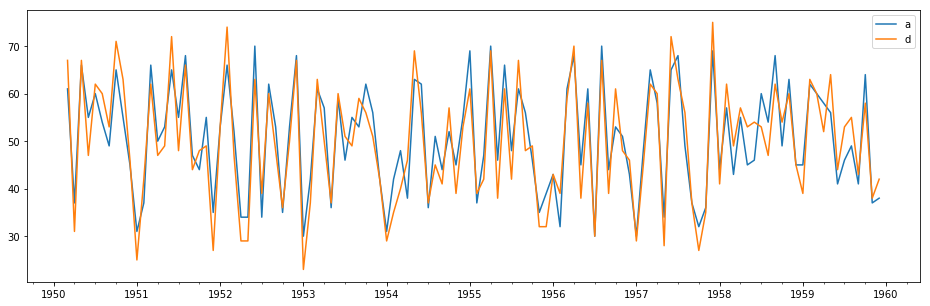

In [241]:
df3['a'].iloc[2:].plot(figsize=(16,5),legend=True);
df3['d'].shift(2).plot(legend=True);

In [242]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


Essentially we're looking for extremely low p-values, which we see at lag 2.<br>


## Differencing
### First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

In [245]:
df3['d1b'] = df3['b'].diff()

df3.head()


,a,b,c,d,d1b
1950-01-01,36,27,0,67,NaN
1950-02-01,58,22,3,31,-5.0
1950-03-01,61,17,5,67,-5.0
1950-04-01,37,15,8,47,-2.0
1950-05-01,66,13,8,62,-2.0


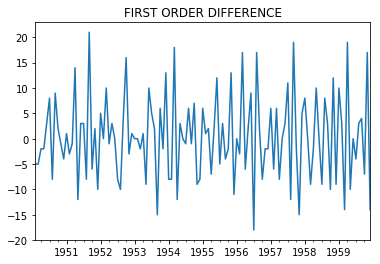

In [246]:
df3['d1b'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);


### Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

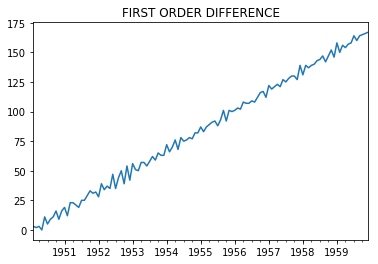

In [247]:
df3['d1c'] = df3['c'].diff()

df3['d1c'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [248]:
df3['d2c'] = df3['c'].diff().diff()

df3[['c','d1c','d2c']].head()

,c,d1c,d2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.0,NaN
1950-03-01,5,2.0,-1.0
1950-04-01,8,3.0,1.0
1950-05-01,8,0.0,-3.0


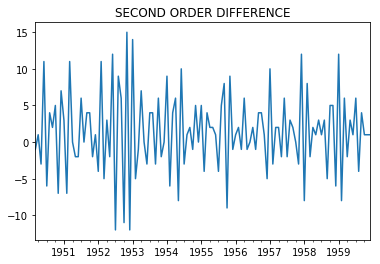

In [250]:
df3['d2c'].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

## ACF & PACF

In [251]:
# Load a non-stationary dataset
df1 = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

### Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [252]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

### Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [253]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

### Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [254]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

### Lag plot

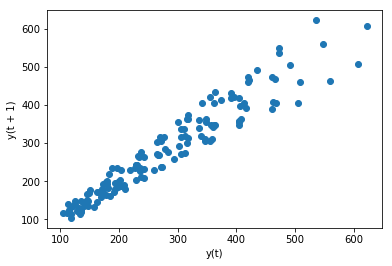

In [255]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

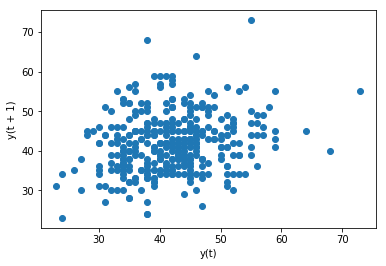

In [256]:
lag_plot(df2['Births']);

### ACF Plots
Plotting the magnitude of the autocorrelations over the first few (20-40) lags can say a lot about a time series.

For example, consider the stationary <strong>Daily Total Female Births</strong> dataset:

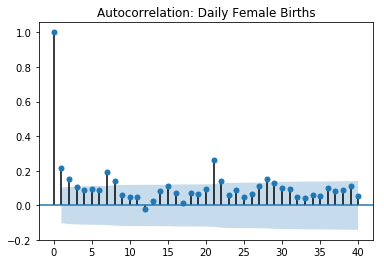

In [257]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

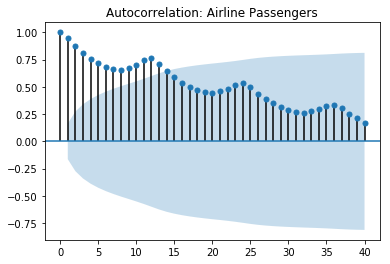

In [258]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

### PACF plots
Partial autocorrelations work best with stationary data. Let's look first at <strong>Daily Total Female Births</strong>:

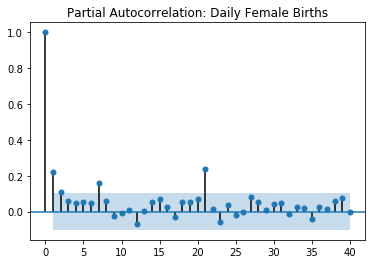

In [259]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

To make the <strong>Airline Passengers</strong> data stationary, we'll first apply <em>differencing</em>:

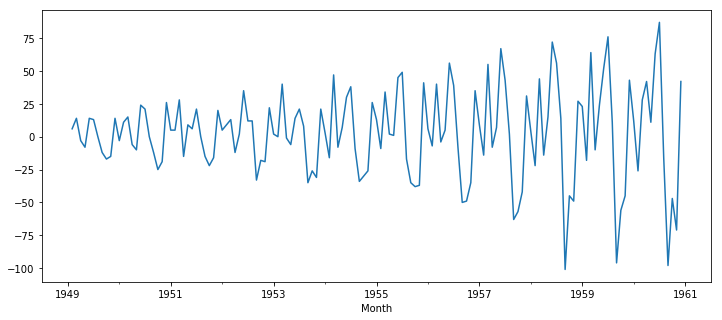

In [260]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot(figsize=(12,5));

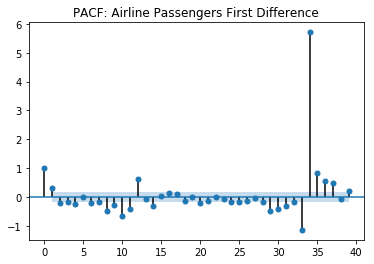

In [261]:
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));

## Autoregressive Model

For this exercise we'll look at monthly U.S. population estimates in thousands from January 2011 to December 2018 (96 records, 8 years of data). Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month.
Source: https://fred.stlouisfed.org/series/POPTHM

In [262]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

In [263]:


# Load the U.S. Population dataset
df = pd.read_csv('Data/uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [264]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


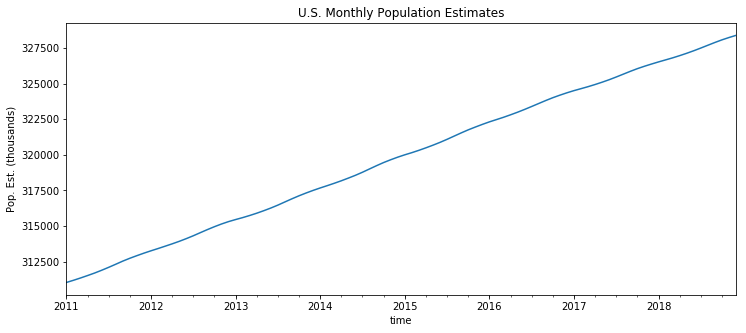

In [265]:
title='U.S. Monthly Population Estimates'
ylabel='Pop. Est. (thousands)'
xlabel='time'

ax = df['PopEst'].plot(figsize=(12,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [266]:
len(df)

96

In [267]:
# Set one year for testing
train = df.iloc[:84]
test = df.iloc[84:]

### Fit an AR(1) Model

In [268]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85923D+00    |proj g|=  1.02742D+00

At iterate    1    f=  6.75878D+00    |proj g|=  2.55863D+00
  ys=-1.531E+00  -gs= 1.027E+00 BFGS update SKIPPED

At iterate    2    f=  6.70426D+00    |proj g|=  1.00806D+00

At iterate    3    f=  6.69606D+00    |proj g|=  8.60864D-02

At iterate    4    f=  6.69600D+00    |proj g|=  1.25810D-03

At iterate    5    f=  6.69600D+00    |proj g|=  3.48166D-05

At iterate    6    f=  6.69600D+00    |proj g|=  9.84581D-03

At iterate    7    f=  6.69588D+00    |proj g|=  1.55438D-01

At iterate    8    f=  6.69506D+00    |proj g|=  2.45831D-02

At iterate    9    f=  6.69492D+00    |proj g|=  1.16438D-01

At iterate   10    f=  6.69483D+00    |proj g|=  1.03043D-01

At iterate   11    f=  6.69432D+00    |proj g|=  1.60998D-01

At iterate   12    f=  6.69428D+00  

 This problem is unconstrained.


In [269]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

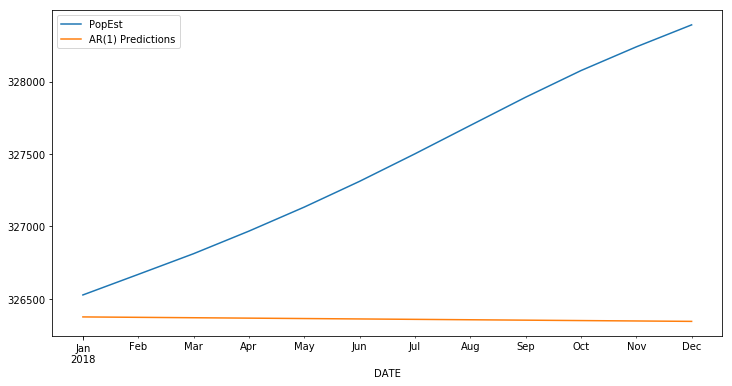

In [270]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

### Fit an AR(2) Model

In [271]:
model = AR(train['PopEst'])
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04080D+00    |proj g|=  4.02404D+00

At iterate    1    f=  4.93557D+00    |proj g|=  2.59521D+00

At iterate    2    f=  4.91430D+00    |proj g|=  6.83652D-01

At iterate    3    f=  4.90993D+00    |proj g|=  7.04819D-01

At iterate    4    f=  4.86415D+00    |proj g|=  2.31105D+00

At iterate    5    f=  4.79584D+00    |proj g|=  4.38908D+00

At iterate    6    f=  4.67083D+00    |proj g|=  6.36961D+00

At iterate    7    f=  4.49588D+00    |proj g|=  6.85753D+00

At iterate    8    f=  4.21069D+00    |proj g|=  4.16124D+00

At iterate    9    f=  4.10859D+00    |proj g|=  4.56839D-01

At iterate   10    f=  4.08259D+00    |proj g|=  5.41401D-02

At iterate   11    f=  4.06446D+00    |proj g|=  2.46398D-01

At iterate   12    f=  4.05861D+00    |proj g|=  2.14309D-01

At iterate   13    f=  4.0

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [272]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

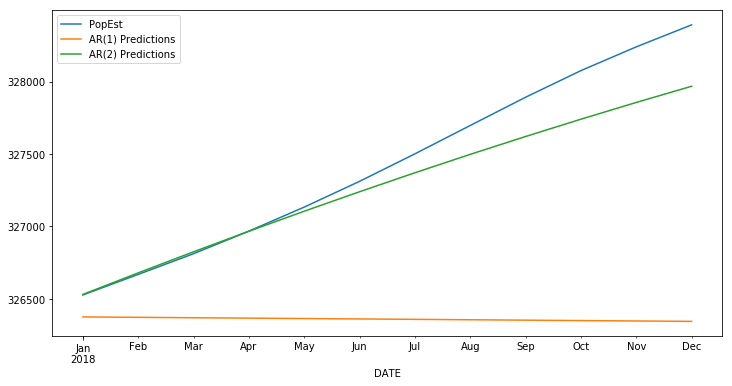

In [273]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

### Fit an AR(p) model where statsmodels chooses p

In [274]:
model = AR(train['PopEst'])
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94196D+00    |proj g|=  6.31405D+00

At iterate    1    f=  4.22398D+00    |proj g|=  9.14494D-01

At iterate    2    f=  4.21863D+00    |proj g|=  7.27217D-01

At iterate    3    f=  4.02789D+00    |proj g|=  3.60368D+00

At iterate    4    f=  3.91167D+00    |proj g|=  3.21124D+00

At iterate    5    f=  3.80721D+00    |proj g|=  2.59803D-01

At iterate    6    f=  3.80225D+00    |proj g|=  4.98091D-01

At iterate    7    f=  3.78180D+00    |proj g|=  1.23617D+00

At iterate    8    f=  3.74895D+00    |proj g|=  3.45359D+00

At iterate    9    f=  3.71353D+00    |proj g|=  3.34627D+00

At iterate   10    f=  3.63224D+00    |proj g|=  4.96226D+00

At iterate   11    f=  3.57143D+00    |proj g|=  1.04102D+00

At iterate   12    f=  3.53998D+00    |proj g|=  2.38727D+00

At iterate   13    f=  3.5

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  3.35458D+00    |proj g|=  2.43896D-01

At iterate   23    f=  3.34395D+00    |proj g|=  3.06608D-01

At iterate   24    f=  3.32214D+00    |proj g|=  1.24271D+00

At iterate   25    f=  3.31956D+00    |proj g|=  2.65351D-01

At iterate   26    f=  3.31811D+00    |proj g|=  1.20198D-01

At iterate   27    f=  3.31669D+00    |proj g|=  1.02983D-01

At iterate   28    f=  3.31369D+00    |proj g|=  1.26177D-01

At iterate   29    f=  3.29875D+00    |proj g|=  1.43043D+00

At iterate   30    f=  3.28579D+00    |proj g|=  2.80613D+00

At iterate   31    f=  3.27347D+00    |proj g|=  2.02330D-01

At iterate   32    f=  3.26600D+00    |proj g|=  8.77201D-01

At iterate   33    f=  3.26237D+00    |proj g|=  1.51967D+00

At iterate   34    f=  3.25714D+00    |proj g|=  9.21700D-01

At iterate   35    f=  3.25369D+00    |proj g|=  1.23504D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

In [275]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

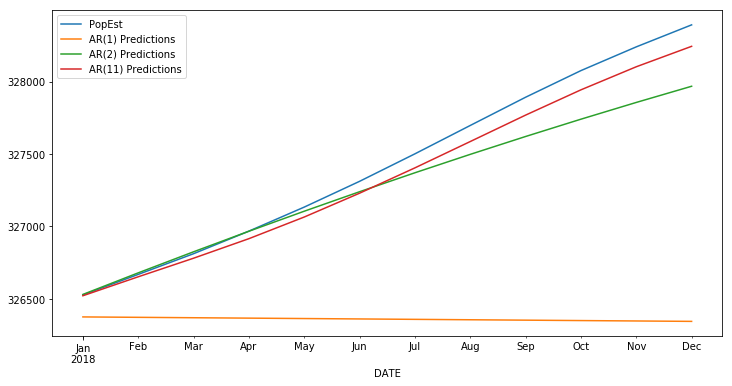

In [276]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

In [277]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11] 

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1534381.813
AR(2) Error: 48068.43267
AR(11) Error: 9245.738969


In [278]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 10.529
AR(2) AIC: 5.1525
AR(11) AIC: 3.6179


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48577D+00    |proj g|=  4.24353D+00

At iterate    1    f=  4.45580D+00    |proj g|=  1.47940D+00

At iterate    2    f=  4.44105D+00    |proj g|=  7.65600D-01

At iterate    3    f=  4.11003D+00    |proj g|=  4.61449D+00

At iterate    4    f=  3.94634D+00    |proj g|=  4.30895D+00

At iterate    5    f=  3.86579D+00    |proj g|=  3.11813D-01

At iterate    6    f=  3.85998D+00    |proj g|=  8.11652D-01

At iterate    7    f=  3.84452D+00    |proj g|=  1.39030D+00

At iterate    8    f=  3.78344D+00    |proj g|=  8.23327D-01

At iterate    9    f=  3.74625D+00    |proj g|=  1.09128D+00

At iterate   10    f=  3.72248D+00    |proj g|=  2.33126D+00

At iterate   11    f=  3.65052D+00    |proj g|=  2.58793D+00

At iterate   12    f=  3.60986D+00    |proj g|=  3.65275D+00

At iterate   13    f=  3.5

 This problem is unconstrained.



At iterate   34    f=  3.20487D+00    |proj g|=  9.00917D-02

At iterate   35    f=  3.20460D+00    |proj g|=  1.28664D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     35     56      1     0     0   1.287D-01   3.205D+00
  F =   3.2046024458040328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 0.000E+00 seconds.



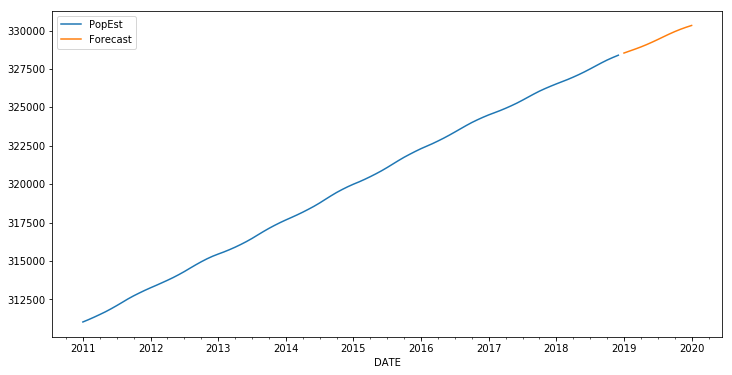

In [279]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+12, dynamic=False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## Choosing ARIMA Orders with auto_arima

In [280]:
# Load a non-stationary dataset
df1 = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [281]:
from pmdarima import auto_arima

Let's look first at the stationary, non-seasonal Daily Female Births dataset:



In [282]:
stepwise_fit = auto_arima(df2['Births'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)          

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=2650.760, BIC=2658.555, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2565.234, BIC=2576.925, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2463.584, BIC=2475.275, Fit time=0.044 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2460.154, BIC=2475.742, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2460.514, BIC=2480.000, Fit time=0.268 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2461.885, BIC=2485.268, Fit time=0.336 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2461.271, BIC=2480.757, Fit time=0.126 seconds
Total fit time: 0.891 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1226.077
Method:                       css-mle   S.D. of innovations              7.000
Date:                Sun, 14 Nov 2021   AIC                           2460.154
Time:                        20:46:45   BIC                           2475.742
Sample:                             1   HQIC                          2466.350
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.014      1.068      0.286      -0.013       0.043
ar.L1.D.y      0.1299      0.056      2.334      0.020       0.021       0.239
ma.L1.D.y     -0.9694      0.019    -51.415      0.000      -1.006      -0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.6996           +0.0000j            7.6996            0.0000
MA.1            1.0316           +0.0000j            1.0316            0.0000
-----------------------------------------------------------------------------
"""

Now let's look at the non-stationary, seasonal Airline Passengers dataset:



In [283]:
stepwise_fit = auto_arima(df1['Thousands of Passengers'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)          

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1024.824, BIC=1039.200, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1033.479, BIC=1039.229, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1022.316, BIC=1033.817, Fit time=0.155 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1022.904, BIC=1034.405, Fit time=0.168 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1022.343, BIC=1030.968, Fit time=0.061 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1021.142, BIC=1035.518, Fit time=0.383 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1016.964, BIC=1034.215, Fit time=0.891 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1033.374, BIC=1047.750, Fit time=1.175 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1018.096, BIC=1038.223, Fit time=1.415 seconds
Fit ARIMA: order=(1, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -502.482
Date:                            Sun, 14 Nov 2021   AIC                           1016.964
Time:                                    20:46:53   BIC                           1034.215
Sample:                                         0   HQIC                          1023.974
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.178      0.032      0.974      -0.344       0.356
ar.L1         -0.3768      0.077     -4.901      0.000      -0.527      -0.226
ar.S.L12       0.6867      0.140      4.894      0.000       0.412       0.962
ar.S.L24       0.3110      0.107      2.909      0.004       0.101       0.521
ma.S.L12      -0.9706      0.455     -2.131      0.033      -1.863      -0.078
sigma2       113.3332     42.740      2.652      0.008      29.565     197.101
===================================================================================
Ljung-Box (Q):                       58.73   Jarque-Bera (JB):                12.12
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.


In [284]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

In [285]:
df1 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

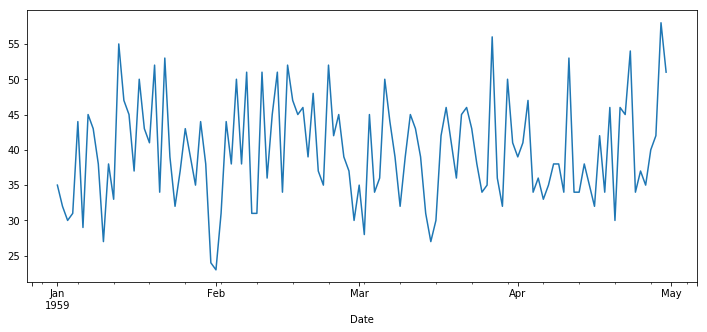

In [286]:
df1['Births'].plot(figsize=(12,5));

In [287]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This tool should give just  𝑝  and  𝑞  value recommendations for this dataset.

In [288]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Sun, 14 Nov 2021   AIC                            822.741
Time:                        20:46:55   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8163      0.108    368.890      0.000      39.605      40.028
ar.L1.y        1.8569      0.081     22.945      0.000       1.698       2.016
ar.L2.y       -0.8815      0.073    -12.038      0.000      -1.025      -0.738
ma.L1.y       -1.8634      0.109    -17.132      0.000      -2.077      -1.650
ma.L2.y        0.8634      0.108      8.023      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0651           -0.0237
AR.2            1.0533           +0.1582j            1.0651            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1582           +0.0000j            1.1582            0.0000
-----------------------------------------------------------------------------
"""

In [289]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]


model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42466D+00    |proj g|=  1.75925D-02

At iterate    5    f=  3.42158D+00    |proj g|=  4.01466D-03

At iterate   10    f=  3.42120D+00    |proj g|=  1.13065D-04

At iterate   15    f=  3.42119D+00    |proj g|=  1.27693D-03

At iterate   20    f=  3.42116D+00    |proj g|=  6.53699D-05

At iterate   25    f=  3.42116D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Sun, 14 Nov 2021   AIC                            627.809
Time:                        20:46:55   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1851      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9663           +0.0000j            1.9663            0.0000
-----------------------------------------------------------------------------
"""

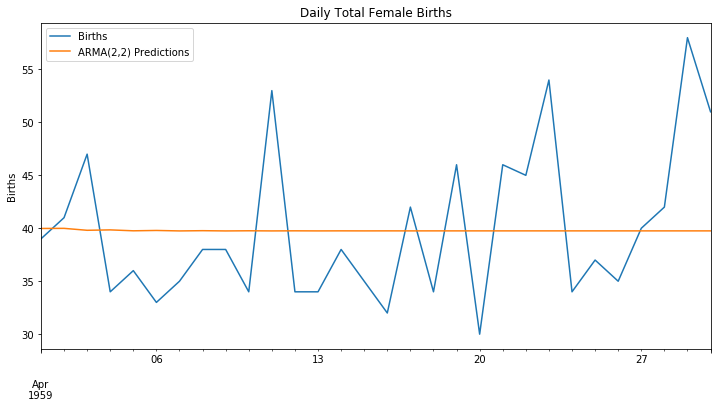

In [290]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Autoregressive Integrated Moving Average - ARIMA(p,d,q)

The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.

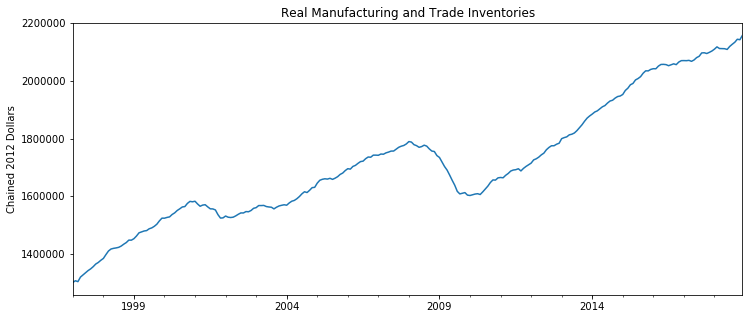

In [291]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' 

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.show()

#### Run an ETS Decomposition (optional)

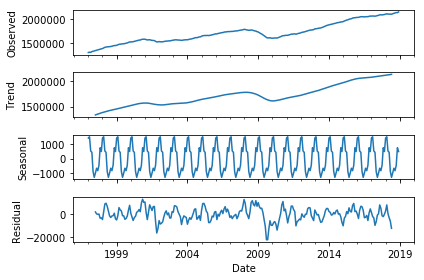

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.

In [293]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.257
Date:                Sun, 14 Nov 2021   AIC                           5228.505
Time:                        20:47:06   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3474.3920   1313.749      2.645      0.009     899.492    6049.292
ar.L1.D.y      0.9037      0.039     23.413      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

#### Run the augmented Dickey-Fuller Test on the First Difference

A PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders.
Alternatively, we can compare the stepwise Akaike Information Criterion (AIC) values across a set of different (p,q) combinations to choose the best combination.

In [294]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


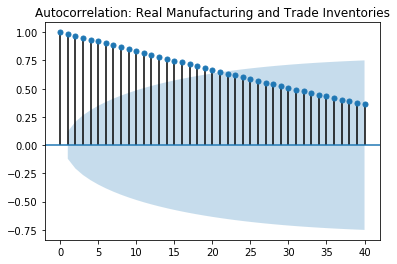

In [295]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

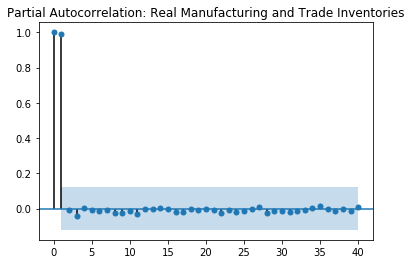

In [296]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [297]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                          stepwise=True)          

stepwise_fit.summary();

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.018 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.084 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.526, BIC=5247.387, Fit time=0.134 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.096 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.126 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.523 seconds


In [298]:
train = df2.iloc[:252]
test = df2.iloc[252:]

model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90598D+00    |proj g|=  1.04858D-03

At iterate    5    f=  9.90596D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.776D-07   9.906D+00
  F =   9.9059562860639172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Sun, 14 Nov 2021   AIC                           4980.790
Time:                        20:47:08   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.874      2.378      0.018     561.666    5833.474
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [299]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

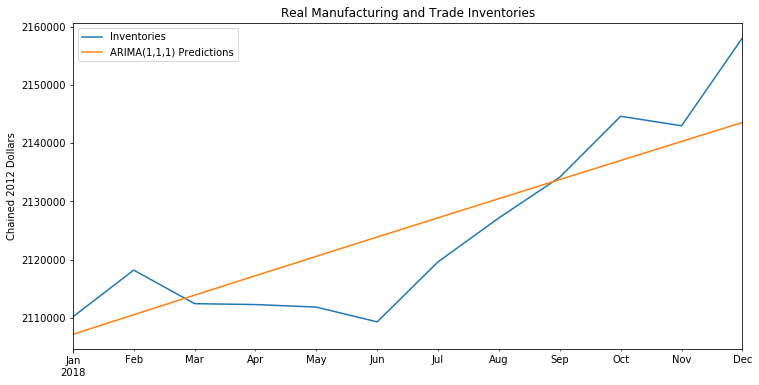

In [300]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.show()

In [301]:
error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

print(f'ARIMA(1,1,1) RMSE Error: {np.sqrt(error):11.10}')

ARIMA(1,1,1) MSE Error:  60677822.2
ARIMA(1,1,1) RMSE Error:  7789.59705


#### Retrain the model on the full data, and forecast the future

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92499D+00    |proj g|=  9.81082D-04

At iterate    5    f=  9.92497D+00    |proj g|=  1.06581D-06

At iterate   10    f=  9.92497D+00    |proj g|=  3.90799D-06

At iterate   15    f=  9.92497D+00    |proj g|=  4.17444D-05

At iterate   20    f=  9.92496D+00    |proj g|=  2.99849D-04

At iterate   25    f=  9.92496D+00    |proj g|=  8.04690D-05

At iterate   30    f=  9.92493D+00    |proj g|=  1.02833D-03

At iterate   35    f=  9.92491D+00    |proj g|=  4.84945D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

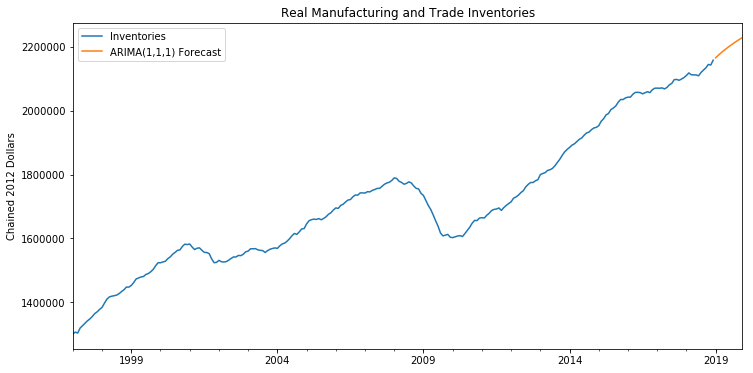

In [302]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

## SARIMA(p,d,q)(P,D,Q)m - Seasonal Autoregressive Integrated Moving Averages


We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters  (𝑝,𝑑,𝑞) , SARIMA accepts an additional set of parameters  (𝑃,𝐷,𝑄)𝑚  that specifically describe the seasonal components of the model. Here  𝑃 ,  𝐷  and  𝑄  represent the seasonal regression, differencing and moving average coefficients, and  𝑚  represents the number of data points (rows) in each seasonal cycle.

In [303]:
df = pd.read_csv('Data/co2_mm_mlo.csv')
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


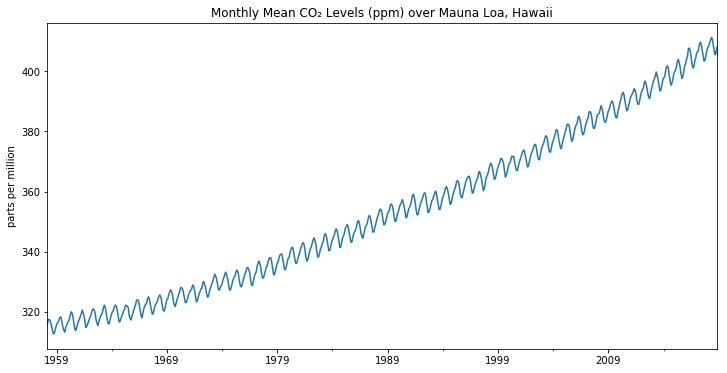

In [304]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

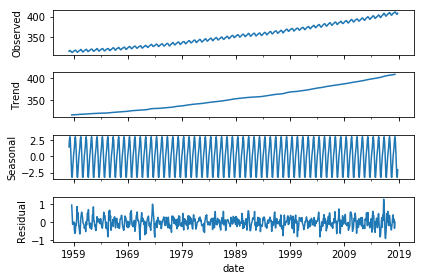

In [305]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

In [306]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.448
Date:                            Sun, 14 Nov 2021   AIC                            424.897
Time:                                    20:47:44   BIC                            447.848
Sample:                                         0   HQIC                           433.753
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.995      0.320      -0.001       0.002
ma.L1         -0.3801      0.034    -11.129      0.000      -0.447      -0.313
ar.S.L12       0.9996      0.000   3214.844      0.000       0.999       1.000
ma.S.L12      -0.8648      0.021    -40.398      0.000      -0.907      -0.823
sigma2         0.0963      0.005     20.334      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       52.18   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.09   Prob(JB):                         0.15
Heteroskedasticity (H):               1.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [307]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

In [308]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34158D+00    |proj g|=  2.55048D-01

At iterate    5    f=  5.36560D-01    |proj g|=  6.05043D+00


 This problem is unconstrained.



At iterate   10    f=  2.96149D-01    |proj g|=  7.52300D-02

At iterate   15    f=  2.95984D-01    |proj g|=  1.55683D-03

At iterate   20    f=  2.94732D-01    |proj g|=  7.22051D-02

At iterate   25    f=  2.86202D-01    |proj g|=  5.76466D-03

At iterate   30    f=  2.86120D-01    |proj g|=  8.89771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     58      1     0     0   9.074D-04   2.861D-01
  F =  0.28612025908985322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search      


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.148
Date:                            Sun, 14 Nov 2021   AIC                            418.296
Time:                                    20:47:45   BIC                            436.591
Sample:                                03-01-1958   HQIC                           425.361
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3710      0.034    -10.817      0.000      -0.438      -0.304
ar.S.L12       0.9997      0.000   3210.637      0.000       0.999       1.000
ma.S.L12      -0.8649      0.023    -37.779      0.000      -0.910      -0.820
sigma2         0.0960      0.005     20.259      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       51.98   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [309]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

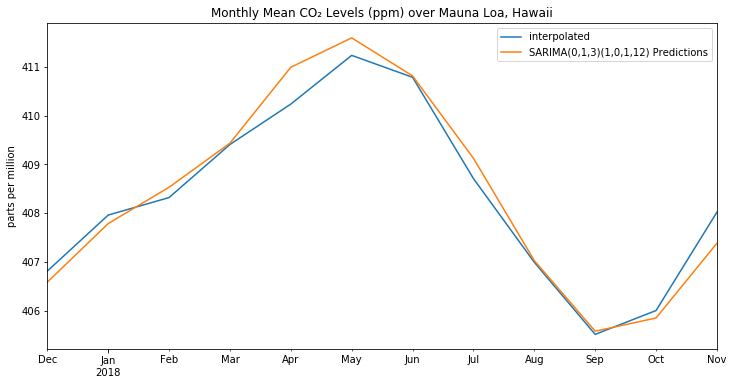

In [310]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [311]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,1)(1,0,1,12) MSE Error: 0.1198654193


In [312]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,1)(1,0,1,12) RMSE Error: 0.3462158565


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33311D+00    |proj g|=  2.60896D-01

At iterate    5    f=  6.18043D-01    |proj g|=  6.24274D+00


 This problem is unconstrained.



At iterate   10    f=  3.26504D-01    |proj g|=  7.54335D-02

At iterate   15    f=  3.12778D-01    |proj g|=  7.77039D-03

At iterate   20    f=  3.11049D-01    |proj g|=  7.91345D-02

At iterate   25    f=  2.91535D-01    |proj g|=  3.38381D-02

At iterate   30    f=  2.87355D-01    |proj g|=  1.81253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     47      1     0     0   9.205D-04   2.873D-01
  F =  0.28730490251963736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search      

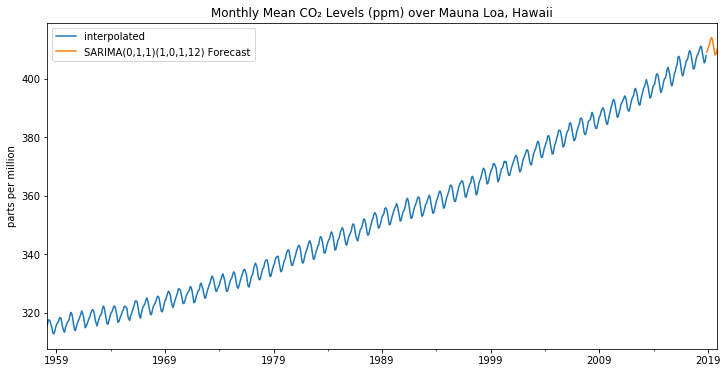

In [313]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,1)(1,0,1,12) Forecast')


title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.



In [314]:
# Load dataset
df = pd.read_csv('Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

df1 = df.dropna()

cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


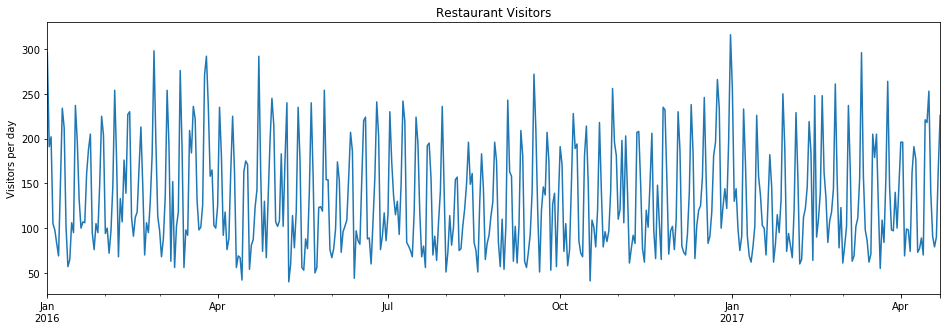

In [315]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

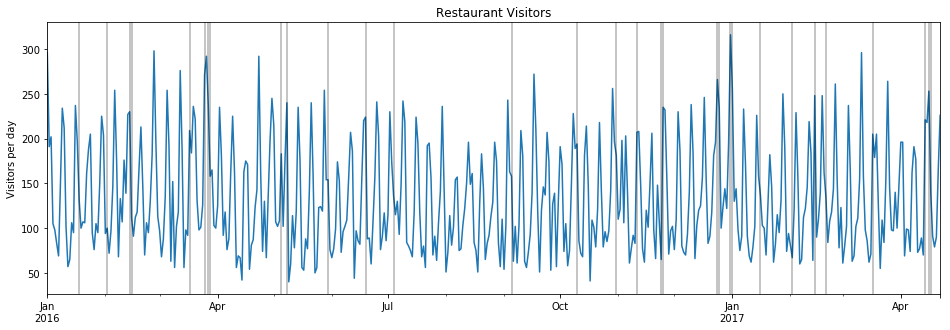

In [316]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

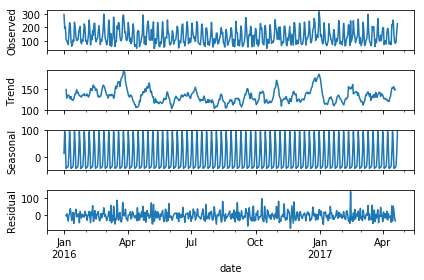

In [317]:
result = seasonal_decompose(df1['total'])
result.plot();

In [318]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [319]:
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Sun, 14 Nov 2021   AIC                           4845.442
Time:                                   20:48:02   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5659      4.363      4.714      0.000      12.015      29.117
ar.L1          0.1897      0.045      4.221      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.3968     86.679     16.468      0.000    1257.510    1597.284
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [320]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38191D+00    |proj g|=  2.35501D-02

At iterate    5    f=  5.28849D+00    |proj g|=  3.92507D-02

At iterate   10    f=  5.25768D+00    |proj g|=  3.44957D-02

At iterate   15    f=  5.17518D+00    |proj g|=  1.00374D-01

At iterate   20    f=  5.10256D+00    |proj g|=  8.57265D-04

At iterate   25    f=  5.10253D+00    |proj g|=  4.06733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sun, 14 Nov 2021   AIC                           4457.403
Time:                                   20:48:02   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

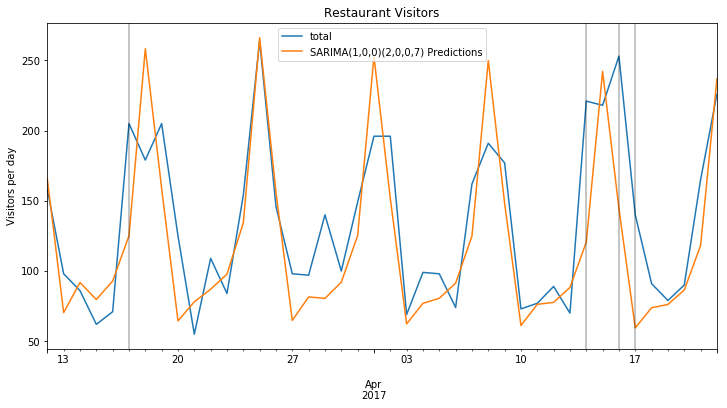

In [321]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [322]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315494


### Now add the exog variable

In [323]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59640D+00    |proj g|=  5.16072D-02



 This problem is unconstrained.


At iterate    5    f=  5.48777D+00    |proj g|=  7.49119D-03

At iterate   10    f=  5.47971D+00    |proj g|=  4.65834D-02

At iterate   15    f=  5.32657D+00    |proj g|=  6.83804D-02

At iterate   20    f=  5.31498D+00    |proj g|=  1.36911D-02

At iterate   25    f=  5.20936D+00    |proj g|=  2.85347D-01

At iterate   30    f=  4.95487D+00    |proj g|=  4.81244D-02

At iterate   35    f=  4.95067D+00    |proj g|=  2.75109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     48      1     0     0   3.045D-05   4.951D+00
  F =   4.9506461931588941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Sun, 14 Nov 2021   AIC                           4326.963
Time:                                   20:48:03   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8931      4.241     15.774      0.000      58.581      75.205
ar.L1          0.2145      0.049      4.376      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.310      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.4551     73.309     15.243      0.000     973.772    1261.138
===================================================================================
Ljung-Box (Q):                      100.97   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

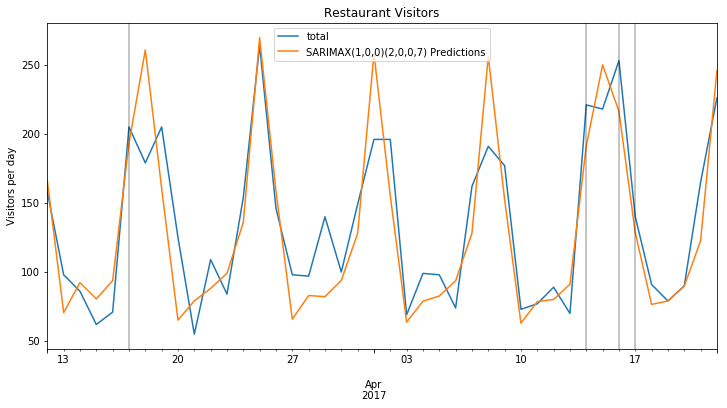

In [324]:

start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [325]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315494

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 950.6342917
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 30.83235787


In [326]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59335D+00    |proj g|=  5.26562D-02

At iterate    5    f=  5.48784D+00    |proj g|=  1.36958D-02


 This problem is unconstrained.



At iterate   10    f=  5.48075D+00    |proj g|=  3.96012D-02

At iterate   15    f=  5.38945D+00    |proj g|=  1.14131D-01

At iterate   20    f=  5.31460D+00    |proj g|=  2.55167D-02

At iterate   25    f=  5.31070D+00    |proj g|=  8.60799D-03

At iterate   30    f=  4.97904D+00    |proj g|=  9.38859D-02

At iterate   35    f=  4.96910D+00    |proj g|=  9.66813D-04
  ys=-4.457E-02  -gs= 9.675E-03 BFGS update SKIPPED

At iterate   40    f=  4.94760D+00    |proj g|=  3.21386D-02

At iterate   45    f=  4.93594D+00    |proj g|=  1.01146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     80      1     1

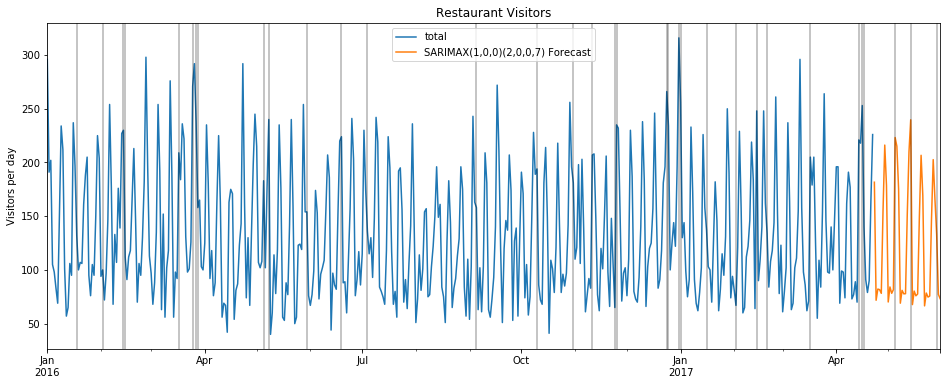

In [327]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## VAR(p) - Vector Autoregression

A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

Carrying this further, the system of equations for a 2-dimensional VAR(3) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \varepsilon_{2,t}$<br><br>

and the system of equations for a 3-dimensional VAR(2) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

The general steps involved in building a VAR model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate order <em>p</em>
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

Recall that to fit a SARIMAX model we passed one field of data as our <em>endog</em> variable, and another for <em>exog</em>. With VAR, both fields will be passed in as <em>endog</em>.

#### Perform standard imports and load dataset
For this analysis we'll also compare money to spending. We'll look at the M2 Money Stock which is a measure of U.S. personal assets, and U.S. personal spending. Both datasets are in billions of dollars, monthly, seasonally adjusted. They span the 21 years from January 1995 to December 2015 (252 records).<br>
Sources: https://fred.stlouisfed.org/series/M2SL https://fred.stlouisfed.org/series/PCE

In [328]:
from statsmodels.tsa.api import VAR, DynamicVAR

In [329]:
# Load datasets
df = pd.read_csv('Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [330]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [331]:
df = df.dropna()
df.shape

(252, 2)

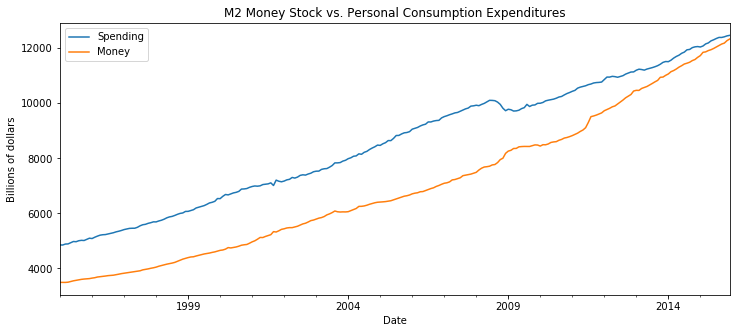

In [332]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

In [333]:
adf_test(df['Money'],title='Money')

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [334]:
adf_test(df['Spending'], title='Spending')

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary



Neither variable is stationary, so we'll take a first order difference of the entire DataFrame and re-run the augmented Dickey-Fuller tests. It's advisable to save transformed values in a new DataFrame, as we'll need the original when we later invert the transormations and evaluate the model.

In [335]:
df_transformed = df.diff()

In [336]:
df_transformed = df_transformed.dropna()
adf_test(df_transformed['Money'], title='MoneyFirstDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingFirstDiff')

Augmented Dickey-Fuller Test: MoneyFirstDiff
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: SpendingFirstDiff
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [337]:
df_transformed = df_transformed.diff().dropna()
adf_test(df_transformed['Money'], title='MoneySecondDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingSecondDiff')

Augmented Dickey-Fuller Test: MoneySecondDiff
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: SpendingSecondDiff
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [338]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [339]:
len(df_transformed)

250

In [340]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

for i in [1,2,3,4,5,6,7]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
#     print('BIC: ', results.bic)
    print()

Order = 1
AIC:  14.178610495220896

Order = 2
AIC:  13.955189367163703

Order = 3
AIC:  13.849518291541038

Order = 4
AIC:  13.827950574458283

Order = 5
AIC:  13.78730034460964

Order = 6
AIC:  13.799076756885809

Order = 7
AIC:  13.797638727913972



In [341]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Nov, 2021
Time:                     20:48:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

#### Predict the next 12 values
Unlike the VARMAX model we'll use in upcoming sections, the VAR .forecast() function requires that we pass in a lag order number of previous observations as well. Unfortunately this forecast tool doesn't provide a DateTime index - we'll have to do that manually.

In [342]:
lag_order = results.k_ar
lag_order

5

In [343]:
z = results.forecast(y=train.values[-lag_order:], steps=12)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [344]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [345]:
idx = pd.date_range('1/1/2015', periods=12, freq='MS')
df_forecast = pd.DataFrame(z, index=idx, columns=['Money2d','Spending2d'])
df_forecast


,Money2d,Spending2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


#### Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the nobs variable we defined during the train/test/split step.

In [346]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [347]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [348]:
df_forecast

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


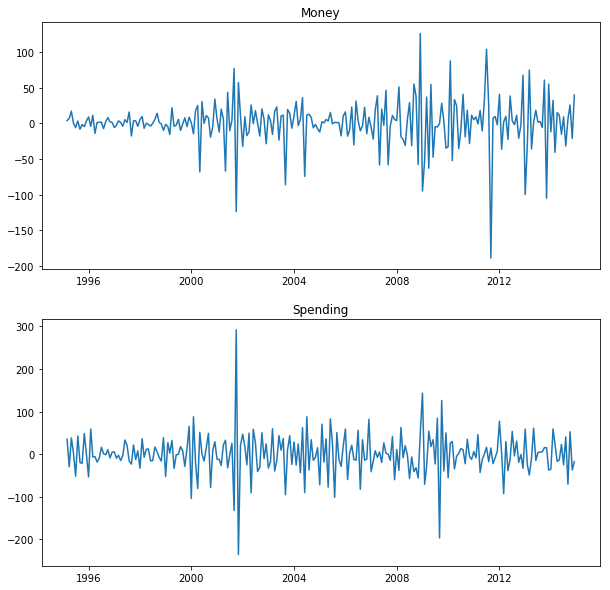

In [349]:
results.plot();

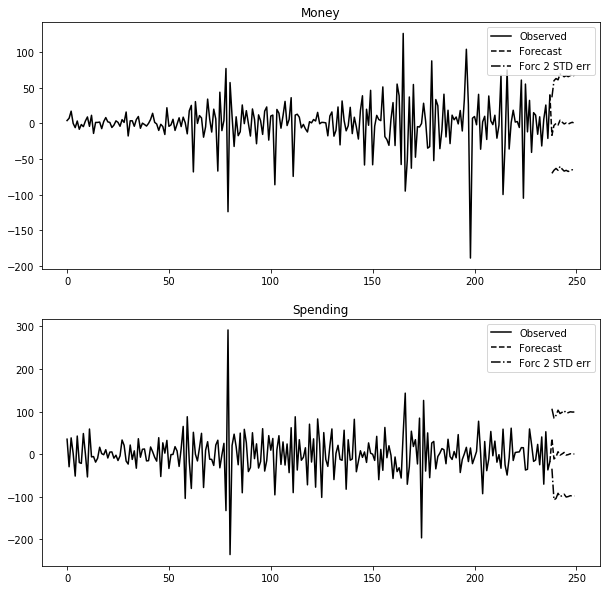

In [350]:
results.plot_forecast(12);

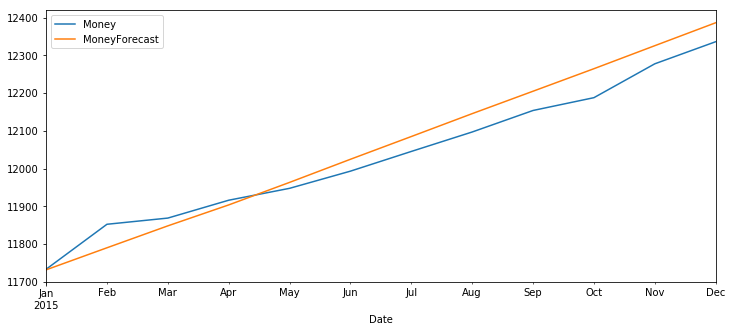

In [351]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

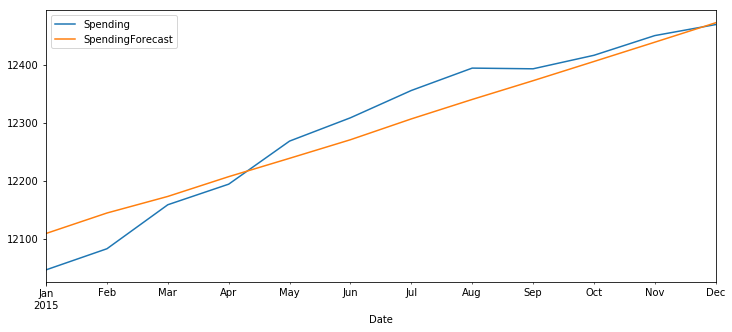

In [352]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [353]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 43.710


In [354]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 37.001


### Let's compare these results to individual AR(5) models

In [355]:
modelM = AR(train['Money'])
AR5fit1 = modelM.fit(maxlag=5,method='mle')
print(f'Lag: {AR5fit1.k_ar}')
print(f'Coefficients:\n{AR5fit1.params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71982D+00    |proj g|=  2.26379D-03

At iterate    1    f=  4.71981D+00    |proj g|=  1.31966D-03

At iterate    2    f=  4.71980D+00    |proj g|=  5.39124D-04

At iterate    3    f=  4.71980D+00    |proj g|=  1.56586D-04

At iterate    4    f=  4.71980D+00    |proj g|=  1.55698D-04

At iterate    5    f=  4.71980D+00    |proj g|=  1.74971D-04

At iterate    6    f=  4.71980D+00    |proj g|=  3.83693D-04

At iterate    7    f=  4.71980D+00    |proj g|=  4.48619D-04

At iterate    8    f=  4.71979D+00    |proj g|=  8.32312D-04

At iterate    9    f=  4.71979D+00    |proj g|=  3.18945D-04

At iterate   10    f=  4.71979D+00    |proj g|=  5.61329D-05

At iterate   11    f=  4.71979D+00    |proj g|=  2.48690D-06

At iterate   12    f=  4.71979D+00    |proj g|=  1.24345D-06

At iterate   13    f=  4.7

 This problem is unconstrained.


In [356]:
start=len(train)
end=len(train)+len(test)-1
z1 = pd.DataFrame(AR5fit1.predict(start=start, end=end, dynamic=False),columns=['Money'])

In [357]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [358]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-16.911062,61.688938,11731.788938
2015-02-01,-11.347190,50.341748,11782.130686
2015-03-01,9.669331,60.011079,11842.141765
2015-04-01,-5.699589,54.311490,11896.453255
2015-05-01,2.353695,56.665185,11953.118441
2015-06-01,5.293518,61.958704,12015.077144
2015-07-01,-3.973283,57.985421,12073.062565
2015-08-01,0.528809,58.514229,12131.576795
2015-09-01,0.898493,59.412723,12190.989517
2015-10-01,-1.244737,58.167986,12249.157503


In [359]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VAR(5) RMSE: {RMSE1:.3f}')
print(f'Money  AR(5) RMSE: {RMSE3:.3f}')

Money VAR(5) RMSE: 43.710
Money  AR(5) RMSE: 36.222


In [360]:
modelS = AR(train['Spending'])
AR5fit2 = modelS.fit(maxlag=5,method='mle')
print(f'Lag: {AR5fit2.k_ar}')
print(f'Coefficients:\n{AR5fit2.params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99260D+00    |proj g|=  1.83480D-03

At iterate    1    f=  4.99259D+00    |proj g|=  3.51719D-04

At iterate    2    f=  4.99258D+00    |proj g|=  7.92255D-05

At iterate    3    f=  4.99258D+00    |proj g|=  4.71623D-05

At iterate    4    f=  4.99258D+00    |proj g|=  2.84217D-05

At iterate    5    f=  4.99258D+00    |proj g|=  2.83329D-05

At iterate    6    f=  4.99258D+00    |proj g|=  5.25802D-05

At iterate    7    f=  4.99258D+00    |proj g|=  1.11999D-04

At iterate    8    f=  4.99258D+00    |proj g|=  1.90870D-04

At iterate    9    f=  4.99258D+00    |proj g|=  2.36255D-04

At iterate   10    f=  4.99258D+00    |proj g|=  1.77103D-04

At iterate   11    f=  4.99258D+00    |proj g|=  9.80549D-05

At iterate   12    f=  4.99258D+00    |proj g|=  2.48690D-05

At iterate   13    f=  4.9

 This problem is unconstrained.


In [361]:
z2 = pd.DataFrame(AR5fit2.predict(start=start, end=end, dynamic=False),columns=['Spending'])
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

z2

,Spending,Spending1d,SpendingForecast
2015-01-01,30.883390,41.483390,12103.483390
2015-02-01,-2.227361,39.256029,12142.739419
2015-03-01,-8.838592,30.417436,12173.156855
2015-04-01,6.673507,37.090944,12210.247799
2015-05-01,-4.483669,32.607275,12242.855074
2015-06-01,-0.535001,32.072274,12274.927347
2015-07-01,3.507001,35.579274,12310.506621
2015-08-01,-1.011478,34.567796,12345.074418
2015-09-01,-0.827617,33.740180,12378.814597
2015-10-01,0.941978,34.682158,12413.496755


In [362]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')
print(f'Spending  AR(5) RMSE: {RMSE4:.3f}')

Spending VAR(5) RMSE: 37.001
Spending  AR(5) RMSE: 34.121



<strong>CONCLUSION:</strong> It looks like the VAR(5) model did <em>not</em> do better than the individual AR(5) models. 

## VARMA(p,q) - Vector Autoregressive Moving Average

In [363]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults


In [364]:
# Load datasets
df = pd.read_csv('Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [365]:
df = df.join(sp)
print(df.shape)
df.head()

(252, 2)


,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [366]:
df = df.dropna()
df.shape

(252, 2)

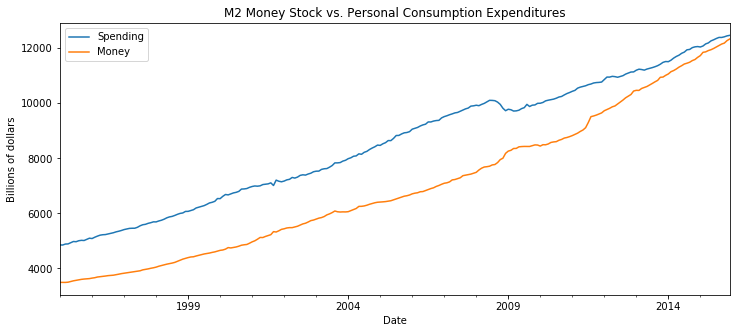

In [367]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

In [368]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 2, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [369]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

It looks like a VARMA(1,2) model is recommended. Note that the  𝑑  term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [370]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [371]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


### Fit the VARMA(1,2) Model

In [372]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.231
,+ intercept,AIC,4606.462
Date:,"Sun, 14 Nov 2021",BIC,4665.490
Time:,20:48:39,HQIC,4630.251
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.97, 28.50",Jarque-Bera (JB):,"550.10, 119.30"
Prob(Q):,"0.00, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.60, 2.91",Skew:,"1.34, -0.35"


In [373]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.113309,36.485707
2015-02-01,-11.234554,-4.443703
2015-03-01,1.535960,-0.183939
2015-04-01,-1.761801,-0.403221
2015-05-01,1.148635,0.204611
2015-06-01,-0.451460,-0.072536
2015-07-01,0.561545,0.115523
2015-08-01,-0.050324,0.004351
2015-09-01,0.324905,0.073014
2015-10-01,0.095932,0.031210


In [374]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()


# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [375]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.113309,36.485707,67.486691,11658.986691,47.085707,12098.485707
2015-02-01,-11.234554,-4.443703,56.252137,11647.752137,42.642004,12094.042004
2015-03-01,1.535960,-0.183939,57.788097,11649.288097,42.458065,12093.858065
2015-04-01,-1.761801,-0.403221,56.026296,11647.526296,42.054844,12093.454844
2015-05-01,1.148635,0.204611,57.174931,11648.674931,42.259455,12093.659455
2015-06-01,-0.451460,-0.072536,56.723471,11648.223471,42.186919,12093.586919
2015-07-01,0.561545,0.115523,57.285016,11648.785016,42.302443,12093.702443
2015-08-01,-0.050324,0.004351,57.234692,11648.734692,42.306793,12093.706793
2015-09-01,0.324905,0.073014,57.559597,11649.059597,42.379807,12093.779807
2015-10-01,0.095932,0.031210,57.655529,11649.155529,42.411017,12093.811017


In [376]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.986691,12098.485707
2015-02-01,11852.4,12082.4,11647.752137,12094.042004
2015-03-01,11868.8,12158.3,11649.288097,12093.858065
2015-04-01,11916.1,12193.8,11647.526296,12093.454844
2015-05-01,11947.6,12268.1,11648.674931,12093.659455
2015-06-01,11993.1,12308.3,11648.223471,12093.586919
2015-07-01,12045.3,12355.4,11648.785016,12093.702443
2015-08-01,12096.8,12394.0,11648.734692,12093.706793
2015-09-01,12153.8,12392.8,11649.059597,12093.779807


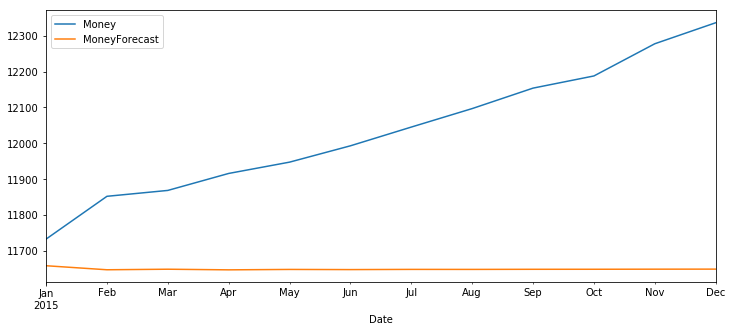

In [377]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

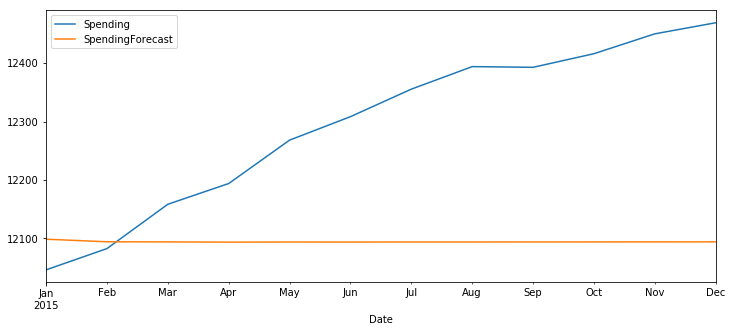

In [378]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [379]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')

Money VARMA(1,2) RMSE: 422.716


In [380]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')

Spending VARMA(1,2) RMSE: 243.799


### Let's compare these results to individual ARMA(1,2) models

In [381]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69925D+00    |proj g|=  1.99310D-02

At iterate    5    f=  4.69846D+00    |proj g|=  1.57954D-02

At iterate   10    f=  4.69775D+00    |proj g|=  6.30589D-03

At iterate   15    f=  4.69637D+00    |proj g|=  2.01572D-03

At iterate   20    f=  4.69627D+00    |proj g|=  5.65770D-04

At iterate   25    f=  4.69626D+00    |proj g|=  3.95328D-04

At iterate   30    f=  4.69626D+00    |proj g|=  5.67546D-05

At iterate   35    f=  4.69626D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Sun, 14 Nov 2021   AIC                           2245.421
Time:                        20:48:45   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3568      0.293     -1.217      0.225      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.117      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.024      -1.100      -0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8024           +0.0000j            2.8024            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.6914           +0.0000j            1.6914            0.5000
-----------------------------------------------------------------------------
"""

In [382]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)


# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498729,64.101271,11734.201271
2015-02-01,-10.946659,53.154613,11787.355884
2015-03-01,4.152320,57.306932,11844.662816
2015-04-01,-1.235583,56.071349,11900.734166
2015-05-01,0.687030,56.758379,11957.492545
2015-06-01,0.000967,56.759346,12014.251891
2015-07-01,0.245781,57.005127,12071.257018
2015-08-01,0.158422,57.163549,12128.420567
2015-09-01,0.189595,57.353144,12185.773711
2015-10-01,0.178471,57.531615,12243.305326


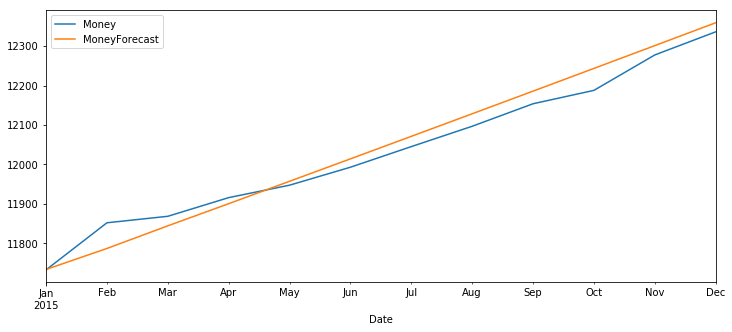

In [383]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
z1['MoneyForecast'].plot(legend=True);

In [384]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 422.716
Money  ARMA(1,2) RMSE: 32.238


In [385]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96828D+00    |proj g|=  1.73355D-03

At iterate    5    f=  4.96818D+00    |proj g|=  3.03313D-04

At iterate   10    f=  4.96812D+00    |proj g|=  7.43405D-05

At iterate   15    f=  4.96812D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   1.776D-07   4.968D+00
  F =   4.9681154693856291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Sun, 14 Nov 2021   AIC                           2374.823
Time:                        20:48:47   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.727      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.506      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.217      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.660      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1439           +0.0000j            4.1439            0.5000
-----------------------------------------------------------------------------
"""

In [386]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)

# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()


z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555867,44.155867,12106.155867
2015-02-01,-3.338281,40.817586,12146.973453
2015-03-01,1.250711,42.068297,12189.041749
2015-04-01,-0.310832,41.757464,12230.799214
2015-05-01,0.220530,41.977994,12272.777208
2015-06-01,0.039718,42.017712,12314.794919
2015-07-01,0.101245,42.118956,12356.913876
2015-08-01,0.080308,42.199265,12399.113140
2015-09-01,0.087432,42.286697,12441.399837
2015-10-01,0.085008,42.371705,12483.771542


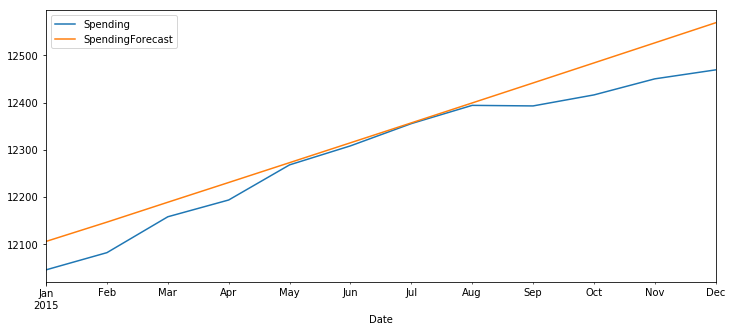

In [387]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
z2['SpendingForecast'].plot(legend=True);

In [388]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 243.799
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.